# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse , Circle

# NFL Colors

In [2]:
nfl_colors = {
    "ARI": "#97233F",  # Arizona Cardinals
    "ATL": "#A71930",  # Atlanta Falcons
    "BAL": "#241773",  # Baltimore Ravens
    "BUF": "#00338D",  # Buffalo Bills
    "CAR": "#0085CA",  # Carolina Panthers
    "CHI": "#0B162A",  # Chicago Bears
    "CIN": "#FB4F14",  # Cincinnati Bengals
    "CLE": "#311D00",  # Cleveland Browns
    "DAL": "#041E42",  # Dallas Cowboys
    "DEN": "#FB4F14",  # Denver Broncos
    "DET": "#0076B6",  # Detroit Lions
    "GB":  "#203731",  # Green Bay Packers
    "HOU": "#03202F",  # Houston Texans
    "IND": "#002C5F",  # Indianapolis Colts
    "JAX": "#006778",  # Jacksonville Jaguars
    "KC":  "#E31837",  # Kansas City Chiefs
    "LAC": "#0080C6",  # Los Angeles Chargers
    "LAR": "#003594",  # Los Angeles Rams
    "LV":  "#000000",  # Las Vegas Raiders
    "MIA": "#008E97",  # Miami Dolphins
    "MIN": "#4F2683",  # Minnesota Vikings
    "NE":  "#002244",  # New England Patriots
    "NO":  "#D3BC8D",  # New Orleans Saints
    "NYG": "#0B2265",  # New York Giants
    "NYJ": "#125740",  # New York Jets
    "PHI": "#004C54",  # Philadelphia Eagles
    "PIT": "#FFB612",  # Pittsburgh Steelers
    "SEA": "#002244",  # Seattle Seahawks
    "SF":  "#AA0000",  # San Francisco 49ers
    "TB":  "#D50A0A",  # Tampa Bay Buccaneers
    "TEN": "#0C2340",  # Tennessee Titans
    "WAS": "#773141",
    "LA": "blue"# Washington Football Team
}



# Custom Style for NFL Report


plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.grid': True,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'axes.labelcolor': 'black',
    'axes.labelsize': 'large',
    'axes.titlesize': 'x-large',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
    'legend.frameon': True,
    'legend.framealpha': 0.7,
    'legend.facecolor': 'white',
    'legend.edgecolor': 'black'
})

# Load Data

In [3]:
tackle_df = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')
plays_df = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')
players_df = pd.read_csv('nfl-big-data-bowl-2024/players.csv')
tracking_df = pd.concat(
                     [
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_8.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_7.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_6.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_5.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_4.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_3.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_2.csv'),
                     pd.read_csv('nfl-big-data-bowl-2024/tracking_week_1.csv')
                    ]
)
model_results_df = pd.concat(
                     [
                     pd.read_feather('nfl-big-data-bowl-2024/week_1_model_output.feather').assign(week =1),
                     pd.read_feather('nfl-big-data-bowl-2024/week_2_model_output.feather').assign(week =2),
                     pd.read_feather('nfl-big-data-bowl-2024/week_3_model_output.feather').assign(week =3),
                     pd.read_feather('nfl-big-data-bowl-2024/week_4_model_output.feather').assign(week =4),
                     pd.read_feather('nfl-big-data-bowl-2024/week_5_model_output.feather').assign(week =5),
                     pd.read_feather('nfl-big-data-bowl-2024/week_6_model_output.feather').assign(week =6),
                     pd.read_feather('nfl-big-data-bowl-2024/week_7_model_output.feather').assign(week =7),
                     pd.read_feather('nfl-big-data-bowl-2024/week_8_model_output.feather').assign(week =8)

                    ]
)
tracking_df['jerseyNumber'] = [str(char).split('.')[0] for char in tracking_df['jerseyNumber']]



In [4]:
model_results_df.columns

Index(['gameId', 'playId', 'yac', 'expected_yac', 'yac_saved', 'r_squared',
       'root_mse', 'week'],
      dtype='object')

# Processing Functions

In [5]:
def calculate_line_to_gain(df: pd.DataFrame):
    # If play is to the right, add yardsToGo to absoluteYardlineNumber
    # If play is to the left, subtract yardsToGo from absoluteYardlineNumber
    line_to_gain = np.where(df['playDirection'] == 'right',
                            df['absoluteYardlineNumber'] + df['yardsToGo'],
                            df['absoluteYardlineNumber'] - df['yardsToGo'])
    return line_to_gain

def create_animation_df(tracking_df:pd.DataFrame, 
                        players_df:pd.DataFrame, 
                        plays_df:pd.DataFrame,
                        model_results_df: pd.DataFrame):
    keep_cols = ['gameId'
                ,'playId'
                ,'frameId'
                ,'displayName'
                ,'x'
                ,'y'
                ,'s'
                ,'dir'
                ,'ballCarrierDisplayName'
                ,'ballCarrierId'
                ,'jerseyNumber'
                ,'absoluteYardlineNumber'
                ,'yard_to_gain'
                ,'club'
                ,'down'
                ,'quarter'
                ,'gameClock'
                ,'event'
                ,'yac'
                ,'expected_yac'
                ,'yac_saved'
                ,'r_squared'
                ,'root_mse'
                ,'week'
            ]
    
    return (tracking_df
           .merge(model_results_df, on =['gameId','playId'], how = 'inner')
           .merge(plays_df, on =['gameId','playId'], how = 'inner')
           .merge(players_df, on = ['nflId','displayName'], how = 'left')
           .assign(yard_to_gain = lambda df: calculate_line_to_gain(df) # Calculate Line To Gain # Change Jeresey Number From Float to Int
           ))[keep_cols]

def _create_football_mask(df):
    return df['displayName'] == 'football'

def _extract_catch_point(df):
    catch_mask = df['event'] == 'pass_outcome_caught'
    return df[catch_mask].rename({'x':'x_at_catch'}, axis=1)[['gameId', 'playId', 'x_at_catch']]

def _merge_and_sort(yac_df, catch_pit):
    return (
        yac_df.merge(catch_pit, on=['gameId', 'playId'], how='inner')
        .sort_values(['gameId', 'playId', 'frameId'])
    )

def _track_yac(df):
    df['yac_track'] = False
    record = False
    for i, row in df.iterrows():
        if row['event'] == 'pass_outcome_caught':
            record = True
  
        df.at[i, 'yac_track'] = record

        if row['event'] in ['tackle', 'out_of_bounds', 'fumble']:
            record = False 
    return df

def create_frame_yac_df(animation_df):
    football_mask = _create_football_mask(animation_df)
    yac_per_frame = animation_df[football_mask].copy()
    
    catch_pit = _extract_catch_point(yac_per_frame)
    yac_per_frame_with_catch = _merge_and_sort(yac_per_frame, catch_pit)
    
    yac_tracked_df = _track_yac(yac_per_frame_with_catch)
    frame_yac_df = (
        yac_tracked_df[yac_tracked_df.yac_track]
        .copy()
        .assign(frame_yac=lambda df: np.abs(df['x'] - df['x_at_catch']))
    )
    return frame_yac_df

def fix_after_play_yac(df):
    
    for i, row in df.iterrows():
        if row['frameId']== 1:
            fix_switch = False
        if row['event'] in ['tackle', 'out_of_bounds', 'fumble'] and row['frameId']!= 1:
            fix_switch = True
        if fix_switch:
            df.at[i,'frame_yac'] = row['yac']
            
    return df

            

# Create Animation DF

In [6]:
animation_df = create_animation_df(tracking_df=tracking_df, players_df=players_df, plays_df = plays_df, model_results_df = model_results_df)

frame_yac_df = create_frame_yac_df(animation_df)[['gameId','playId','frameId','frame_yac']]

animation_df = (
                animation_df
               .merge(frame_yac_df,on=['gameId','playId','frameId'],how='left')
               .assign(frame_yac = lambda df: df['frame_yac'].fillna(0))
               .pipe(fix_after_play_yac)
             )
animation_df

,gameId,playId,frameId,displayName,x,y,s,dir,ballCarrierDisplayName,ballCarrierId,...,quarter,gameClock,event,yac,expected_yac,yac_saved,r_squared,root_mse,week,frame_yac
0,2022102700,68,1,Kevin Zeitler,25.820000,28.560000,0.92,327.70,Mark Andrews,46155,...,1,14:54,NaN,12.360001,7.061792,-5.298209,0.454730,3.971213,8,0.000000
1,2022102700,68,2,Kevin Zeitler,25.780000,28.640000,0.87,337.03,Mark Andrews,46155,...,1,14:54,NaN,12.360001,7.061792,-5.298209,0.454730,3.971213,8,0.000000
2,2022102700,68,3,Kevin Zeitler,25.770000,28.720000,0.78,348.42,Mark Andrews,46155,...,1,14:54,pass_arrived,12.360001,7.061792,-5.298209,0.454730,3.971213,8,0.000000
3,2022102700,68,4,Kevin Zeitler,25.770000,28.790000,0.72,1.00,Mark Andrews,46155,...,1,14:54,NaN,12.360001,7.061792,-5.298209,0.454730,3.971213,8,0.000000
4,2022102700,68,5,Kevin Zeitler,25.790000,28.860000,0.70,15.53,Mark Andrews,46155,...,1,14:54,NaN,12.360001,7.061792,-5.298209,0.454730,3.971213,8,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895126,2022091200,3467,21,football,42.130001,19.350000,2.26,NaN,Will Dissly,46189,...,4,6:08,tackle,1.350002,1.037298,-0.312705,0.457753,3.891884,1,1.350002
1895127,2022091200,3467,22,football,42.310001,19.309999,1.82,NaN,Will Dissly,46189,...,4,6:08,NaN,1.350002,1.037298,-0.312705,0.457753,3.891884,1,1.350002
1895128,2022091200,3467,23,football,42.490002,19.379999,1.58,NaN,Will Dissly,46189,...,4,6:08,NaN,1.350002,1.037298,-0.312705,0.457753,3.891884,1,1.350002
1895129,2022091200,3467,24,football,42.610001,19.459999,1.28,NaN,Will Dissly,46189,...,4,6:08,NaN,1.350002,1.037298,-0.312705,0.457753,3.891884,1,1.350002


# Plot Field

In [81]:
def plot_play(frame_df, ax, nfl_colors):
    ax.clear()
    # Find the unique clubs involved in this specific play
    unique_clubs = frame_df[frame_df['club'] != 'football']['club'].unique()
    team1, team2 = unique_clubs[:2]
    # Initialize a dictionary for the legend handles to ensure unique labels
    legend_handles = {}

    # Plot player positions with colors based on 'club'
    for _, row in frame_df.iterrows():
        if row['club'] != 'football':
            club_color = nfl_colors[row['club']]
            if row['club'] not in legend_handles:
                legend_handles[row['club']] = plt.Line2D([0], [0], marker='o', color=club_color, markersize=10, linestyle='')

            ax.plot(row['x'], row['y'], 'o', markersize=15, color=club_color, zorder=2)
            ax.text(row['x'], row['y'], row['jerseyNumber'], fontsize=9, ha='center', va='center', zorder=2)

            if row['displayName'] == row['ballCarrierDisplayName']:
                ball_carrier_circle = Circle((row['x'], row['y']), radius=2.8, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(ball_carrier_circle)
                legend_handles['Ball Carrier'] = plt.Line2D([0], [0], marker='o', color='red', markerfacecolor='none', markersize=10, linestyle='')

            radians = np.radians((row['dir'] - 90) * -1)
            arrow_scale = 0.5
            dx = np.cos(radians) * row['s'] * arrow_scale
            dy = np.sin(radians) * row['s'] * arrow_scale
            ax.arrow(row['x'], row['y'], dx, dy, head_width=0.5, head_length=0.5, fc='black', ec='black')

    # Plot the football
    football_row = frame_df[frame_df['displayName'] == 'football'].iloc[0]
    football_ellipse = Ellipse((football_row['x'], football_row['y']), width=2.3, height=1.3, color='brown', zorder=3)
    ax.add_patch(football_ellipse)

    # Field setup
    ax.set_xlim([0, 120])
    ax.set_ylim([0, 53.3])
    ax.set_facecolor('white')
    ax.grid(True, color='grey', linestyle='--', linewidth=0.5)

    # Yard lines, hash marks, and end zones
    for x in range(20, 110, 10):
        ax.vlines(x, 0, 53.3, colors='black', lw=2,zorder =1)
        yard_line = x - 10 if x < 60 else 120 - (x + 10)
        off_sideline = 4
        for vert_pos in [off_sideline, 53.3-off_sideline]:
            ax.text(x, vert_pos, str(yard_line), color='black', ha='center', fontsize=10, weight='bold',zorder =1)

    for x in range(10, 110, 1):
        if 10 < x < 110:
            hash_mark_length = 0.5
            left_hash_y, right_hash_y = 18.21, 53.3 - 18.21
            ax.plot([x, x], [left_hash_y - hash_mark_length/2, left_hash_y + hash_mark_length/2], color='black', lw=2,zorder =1)
            ax.plot([x, x], [right_hash_y - hash_mark_length/2, right_hash_y + hash_mark_length/2], color='black', lw=2,zorder =1)

    # Extract line of scrimmage and line to gain values
    line_of_scrimmage = frame_df['absoluteYardlineNumber'].iloc[0]
    line_to_gain = frame_df['yard_to_gain'].iloc[0]

    # Plot line of scrimmage (dark blue) and line to gain (bright yellow)
    ax.axvline(x=line_of_scrimmage, color='darkblue', lw=2, label='Line of Scrimmage')
    ax.axvline(x=line_to_gain, color='yellow', lw=2, label='Line to Gain')

    ax.axvspan(0, 10, color='navy', alpha=0.3)
    ax.axvspan(110, 120, color='navy', alpha=0.3)
    ax.hlines([0, 53.3], xmin=0, xmax=120, colors='black', lw=2,zorder =1)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Expected YAC = {np.round(row['expected_yac'],2)}, Actual YAC = {np.round(row['yac'],2)}, YAC Saved = {np.round(row['yac_saved'],2)}")

    # Legends and titles
    handles, labels = [], []
    for club in unique_clubs:
        handles.append(legend_handles[club])
        labels.append(club)
    ax.legend(handles, labels, loc='upper right', fontsize='small')

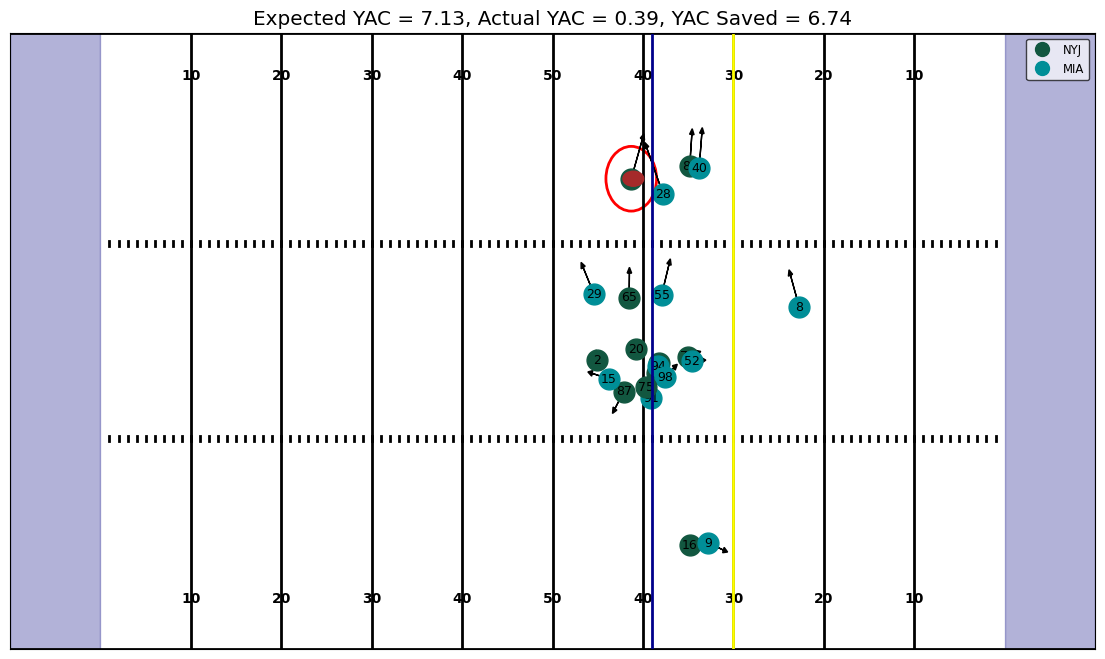

In [98]:
game_id = 2022100907 
play_id = 295 
animation_df
play_frame_game_mask = (animation_df['playId'] ==play_id) & (animation_df['frameId'] == 5) & (animation_df['gameId'] == game_id)
fig, ax = plt.subplots(figsize=(14, 8))
frame_df = animation_df[play_frame_game_mask].reset_index(drop = True)
plot_play(frame_df, ax, nfl_colors)



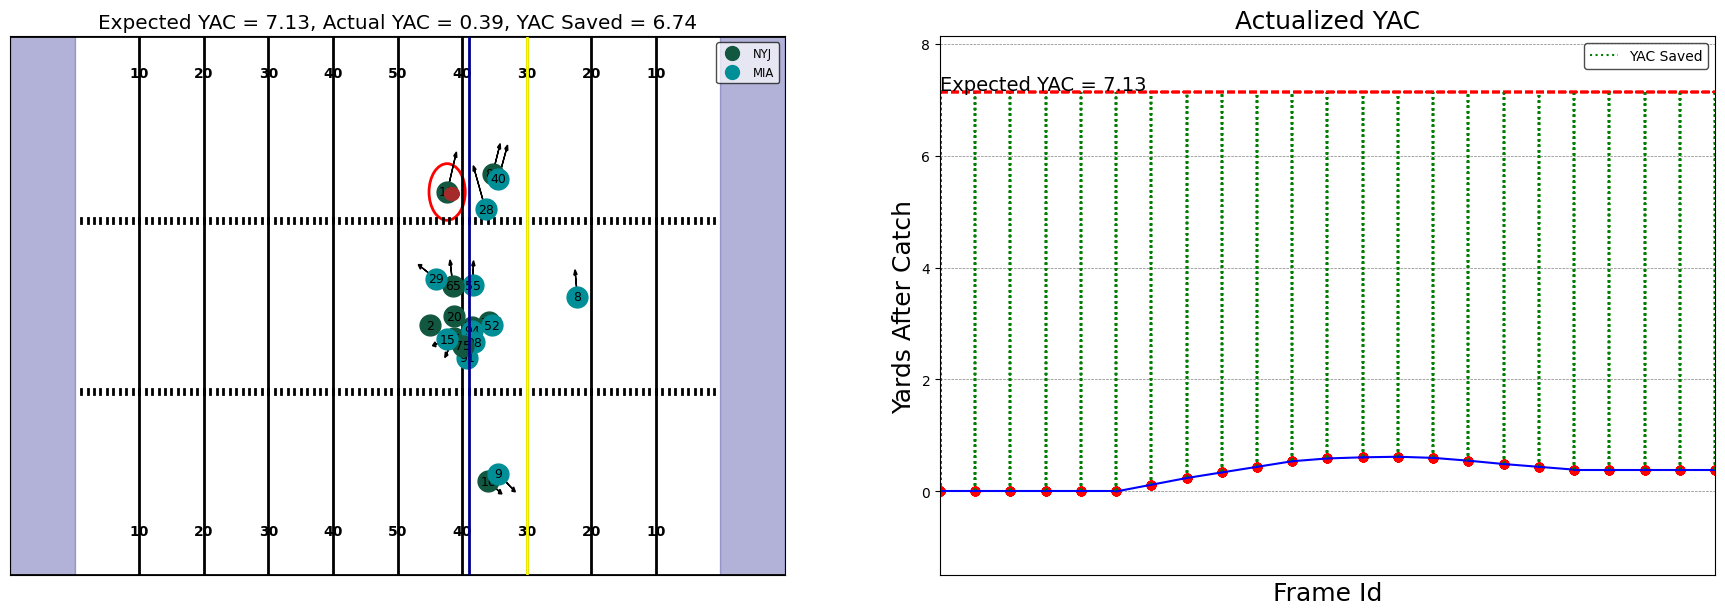

In [101]:
def plot_yac(frame_df, prev_frame_df, ax2, all_frame_ids):
    global one_time_switch
    expected_yac = frame_df['expected_yac'].iloc[0]

    if one_time_switch:
        one_time_switch = False
        ax2.set_title('Actualized YAC', fontsize=18)
        ax2.set_xlabel('Frame Id', fontsize=18)
        ax2.set_ylabel('Yards After Catch', fontsize=18)
        ax2.set_ylim(-1.5, expected_yac + 1)
        ax2.set_xlim(min(all_frame_ids), max(all_frame_ids))

        # Annotate expected YAC directly on the line
        ax2.annotate(f'Expected YAC = {np.round(expected_yac, 2)}', xy=(1, expected_yac + 0.05), fontsize=14)

        ax2.plot([], [], color='green', linestyle='dotted', label='YAC Saved')

        ax2.legend(loc='best')

    ax2.scatter(frame_df['frameId'], frame_df['frame_yac'], c='red')
    if prev_frame_df is not None:
        ax2.plot([prev_frame_df['frameId'].iloc[0], frame_df['frameId'].iloc[0]],
                 [prev_frame_df['frame_yac'].iloc[0], frame_df['frame_yac'].iloc[0]], 'b-')

    ax2.axhline(y=expected_yac, color='r', linestyle='--')

    for index, row in frame_df.iterrows():
        current_frame_id = row['frameId']
        current_yac = row['frame_yac']
        ax2.vlines(x=current_frame_id, ymin=min(current_yac, expected_yac), ymax=max(current_yac, expected_yac), colors='green', linestyles='dotted')

    # Clear x-axis ticks (frame id numbers) while keeping the label
    ax2.set_xticks([])
# Prepare data
one_time_switch = True

play_frame_mask = (animation_df['playId'] == play_id) & (animation_df['gameId'] == game_id)
test_df = animation_df[play_frame_mask].copy()
frames_df = [test_df[test_df['frameId'] == frame] for frame in sorted(test_df['frameId'].unique())]
all_frame_ids = sorted(test_df['frameId'].unique())




# Setup figure and axes
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(22, 7))
    # Set the x-axis ticks
# Define the update function for the animation
def update(frame_index, frames_df, ax, ax2, nfl_colors, all_frame_ids):
    frame_df = frames_df[frame_index]
    prev_frame_df = frames_df[frame_index - 1] if frame_index > 0 else None
    plot_play(frame_df, ax, nfl_colors)
    plot_yac(frame_df, prev_frame_df, ax2, all_frame_ids)

# Create the animation using FuncAnimation
ani = FuncAnimation(fig, update, frames=len(frames_df), fargs=(frames_df, ax, ax2, nfl_colors, all_frame_ids), blit=False, interval = 100)

# Save the animation
ani.save('report_gifs/dolphins_jets_week_5.gif', writer='pillow', fps=1500)


In [102]:
from IPython.display import Image
Image(url='report_gifs/dolphins_jets_week_5.gif')

In [ ]:
3684

In [21]:
model_results_df.sort_values('yac_saved', ascending = False).head(40)

,gameId,playId,yac,expected_yac,yac_saved,r_squared,root_mse,week
139,2022101604,2230,-1.459999,9.670242,11.130241,0.445661,3.711859,6
331,2022092512,641,-0.600000,10.105019,10.705020,0.428774,4.231275,3
156,2022091805,257,0.980003,10.879891,9.899888,0.476953,3.638928,2
40,2022091100,458,4.490000,13.754896,9.264896,0.457753,3.891884,1
82,2022091102,756,-2.400002,6.433955,8.833957,0.457753,3.891884,1
7,2022102000,591,-0.279999,8.384310,8.664309,0.442664,3.890706,7
395,2022091113,2954,1.529999,10.053012,8.523014,0.457753,3.891884,1
89,2022091102,2894,0.459999,8.850479,8.390480,0.457753,3.891884,1
276,2022091109,1520,6.040001,14.397013,8.357012,0.457753,3.891884,1
230,2022102308,833,2.080002,10.276653,8.196651,0.442664,3.890706,7


* Candidate Plays To Show
    2022101604 2230 Christian Wilinson on Justin Jefferson
    2022091805 257 
    2022100911 1376 Devonta Play
    2022101610 2624
    2022100907 295 Cater Kohu on Braxton Berrios Week 5
    2022100203 3684 Cardinals Defense Swarms on DJ Moore

In [103]:
play_mask = (plays_df['playId'] == play_id) & (plays_df['gameId'] == game_id)
plays_df[play_mask][['quarter','down','gameClock']]

,quarter,down,gameClock
5019,1,2,11:14


In [66]:
game_id

2022100203

In [67]:
play_id

3684

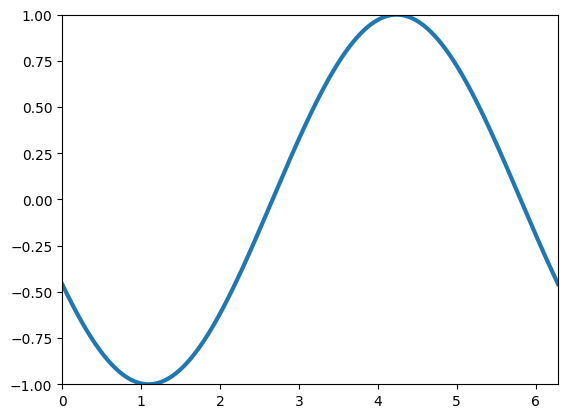

In [7]:
# Creating a figure and axis
fig, ax = plt.subplots()

# Setting up the line object (note: we are just creating the "empty" line)
line, = ax.plot([], [], lw=3)

# Setting the axes limits
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1, 1)

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Function to update the figure
def update(frame):
    x = np.linspace(0, 2*np.pi, 1000)
    y = np.sin(x + frame/10)
    line.set_data(x, y)
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True)

# Save as GIF
ani.save('sine_wave.gif', writer='pillow', fps=30)

In [6]:
from IPython.display import Image
Image(url='sine_wave_2.gif')

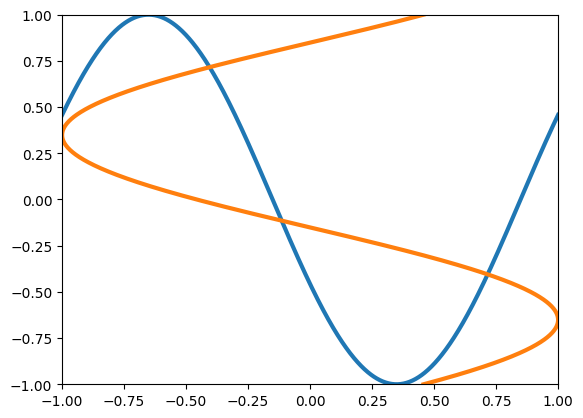

In [5]:
# Creating a figure and axis
fig, ax = plt.subplots()

# Setting up the line objects for horizontal and vertical sine waves
line_horizontal, = ax.plot([], [], lw=3)
line_vertical, = ax.plot([], [], lw=3)

# Setting the axes limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# Initialization function: plot the background of each frame
def init():
    line_horizontal.set_data([], [])
    line_vertical.set_data([], [])
    return line_horizontal, line_vertical

# Function to update the figure
def update(frame):
    # Horizontal Sine Wave
    x_horizontal = np.linspace(-1, 1, 1000)
    y_horizontal = np.sin(x_horizontal * np.pi + frame / 10)
    line_horizontal.set_data(x_horizontal, y_horizontal)

    # Vertical Sine Wave
    y_vertical = np.linspace(-1, 1, 1000)
    x_vertical = np.sin(y_vertical * np.pi + frame / 10)
    line_vertical.set_data(x_vertical, y_vertical)

    return line_horizontal, line_vertical

# Create the animation
ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True)

# Save as GIF
ani.save('sine_wave_2.gif', writer='pillow', fps=30)


0

count    3069.000000
mean       -0.415008
std         3.945023
min       -29.243521
25%        -1.562508
50%         0.249672
75%         1.743693
max        11.130241
Name: yac_saved, dtype: float64

<Axes: xlabel='yac_saved', ylabel='Count'>

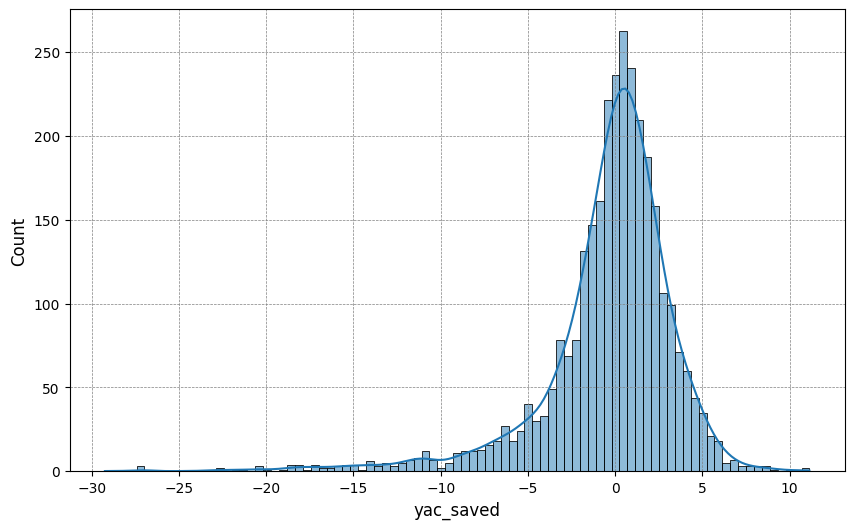

In [87]:
sns.histplot(model_results_df['yac_saved'],kde=True)

In [89]:
model_results_plot_df = model_results_df.drop_duplicates('week')

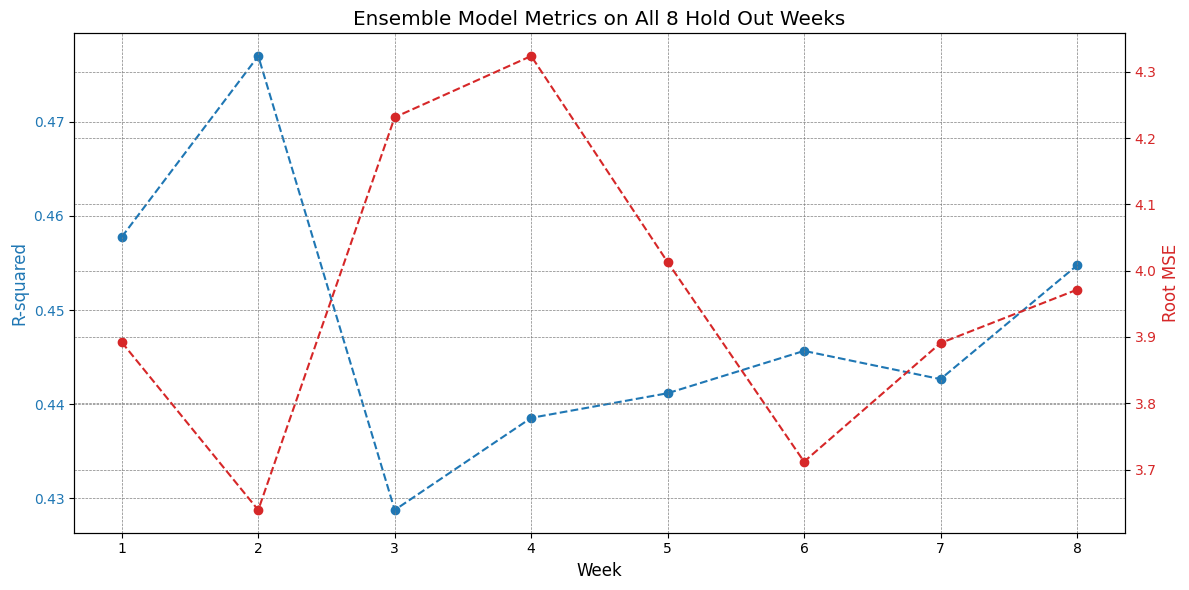

In [91]:
def plot_weekly_performance_with_lines(weeks, r_squared_values, root_mse_values, title=''):
    if not title:
        title = 'Weekly Performance: R-squared and Root MSE'

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # First axis for R-squared
    color = 'tab:blue'
    ax1.set_xlabel('Week')
    ax1.set_ylabel('R-squared', color=color)
    ax1.scatter(weeks, r_squared_values, color=color)
    ax1.plot(weeks, r_squared_values, color=color, linestyle='dashed') # Connecting line for R-squared
    ax1.tick_params(axis='y', labelcolor=color)

    # Second axis for Root MSE
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Root MSE', color=color)  # we already handled the x-label with ax1
    ax2.scatter(weeks, root_mse_values, color=color)
    ax2.plot(weeks, root_mse_values, color=color, linestyle='dashed') # Connecting line for Root MSE
    ax2.tick_params(axis='y', labelcolor=color)

    plt.title(title)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()


weeks,r_squareds, root_mse = model_results_plot_df['week'], model_results_plot_df['r_squared'],model_results_plot_df['root_mse']

plot_weekly_performance_with_lines(weeks,r_squareds,root_mse,"Ensemble Model Metrics on All 8 Hold Out Weeks")
